In [1]:
!rm -rf improved_wgan_training
!git clone https://github.com/igul222/improved_wgan_training.git
!rm -rf mAP/samples/cifar10/*

Cloning into 'improved_wgan_training'...
remote: Enumerating objects: 121, done.
remote: Total 121 (delta 0), reused 0 (delta 0), pack-reused 121
Receiving objects: 100% (121/121), 172.64 KiB | 966.00 KiB/s, done.
Resolving deltas: 100% (54/54), done.


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:7: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "</usr/local/lib/python2.7/dist-packages/decorator.pyc:decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python2.7/dist-packages

improved_wgan_training/tflib/plot.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/application.py", line 657, in launch_instance
    app.initialize(argv)
  File "</usr/local/lib/python2.7/dist-packages/decorator.pyc:decorator-gen-121>", line 2, in initialize
  File "/usr/local/lib/python2.7/dist-packages/traitlets/config/applic

iter 99	disc cost	-4.59215211868


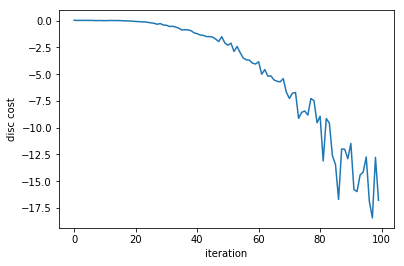

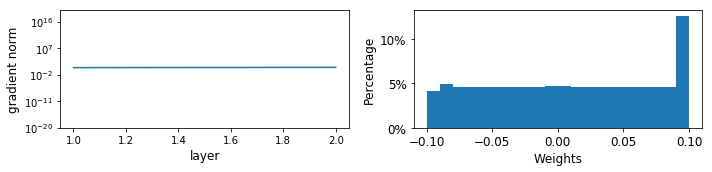

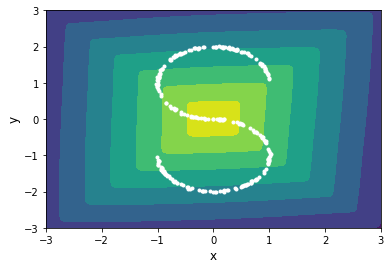

iter 199	disc cost	-55.9852409363


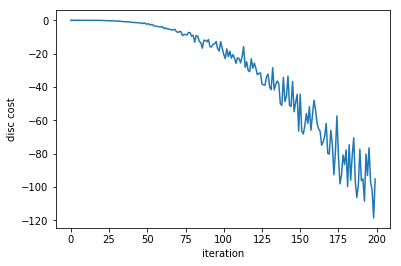

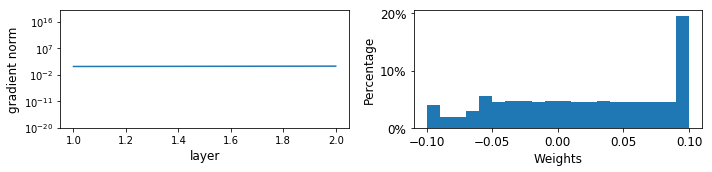

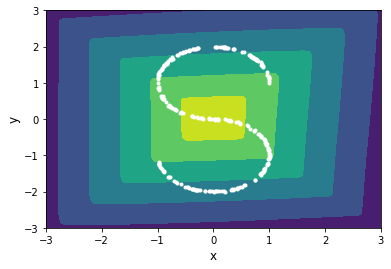

iter 299	disc cost	-187.053207397


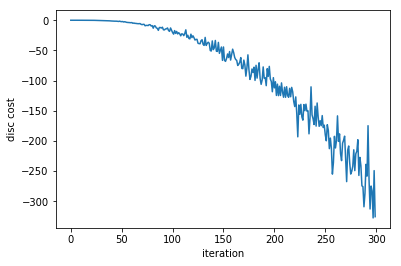

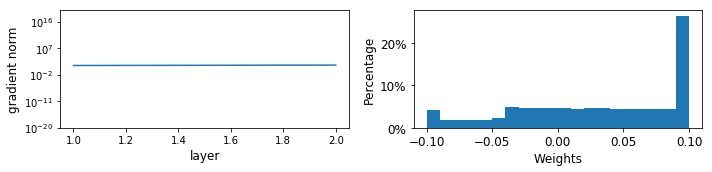

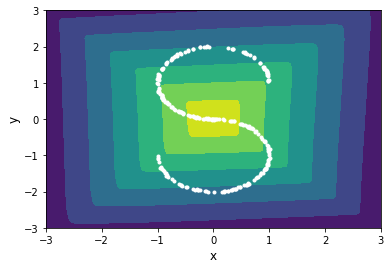

iter 399	disc cost	-366.167266846


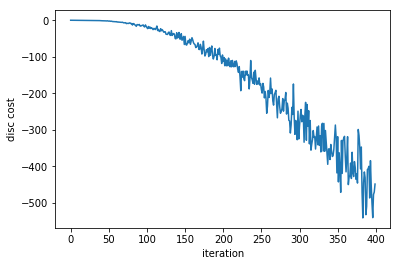

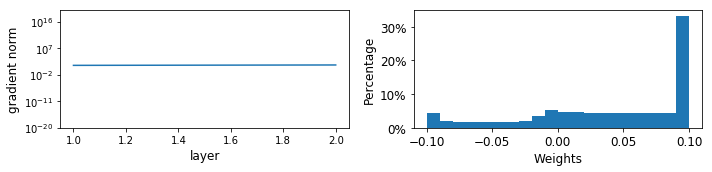

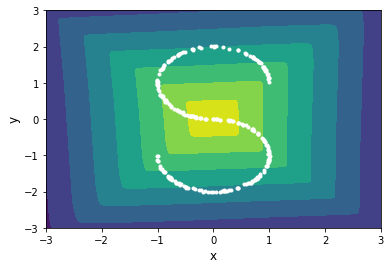

iter 499	disc cost	-554.747558594


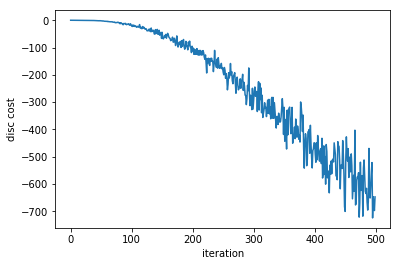

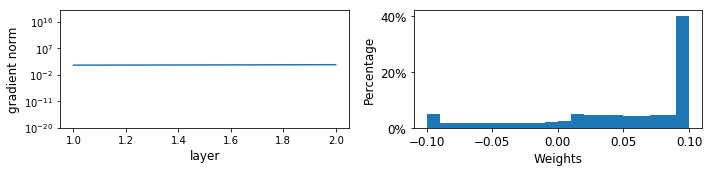

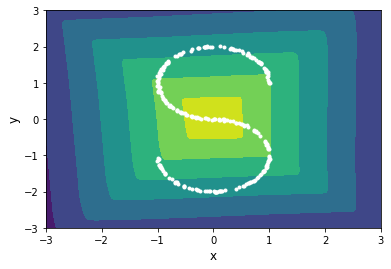

iter 599	disc cost	-718.866271973


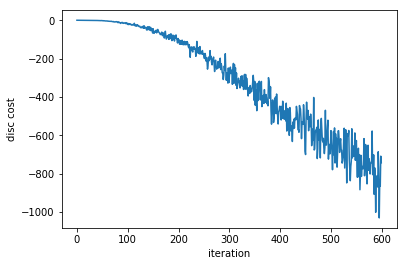

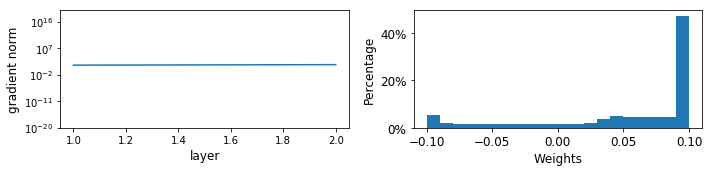

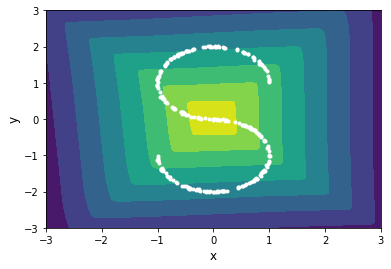

iter 699	disc cost	-865.125915527


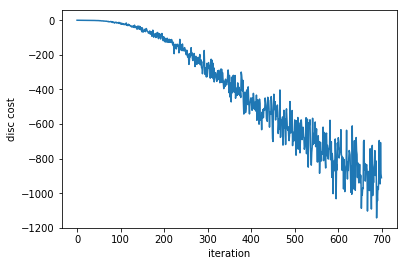

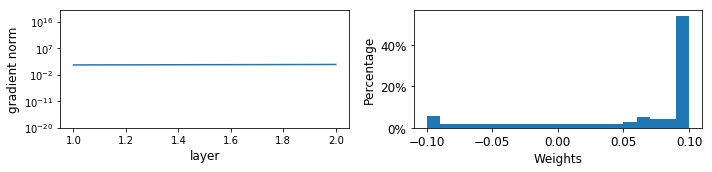

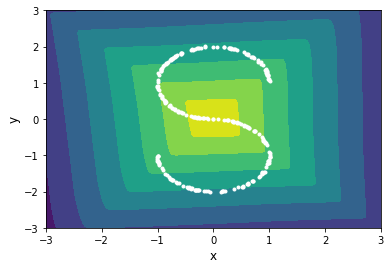

iter 799	disc cost	-960.814697266


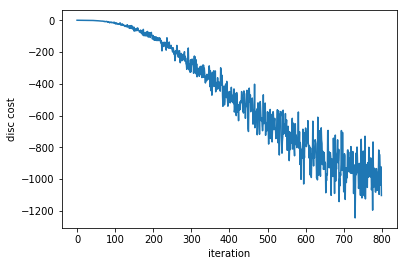

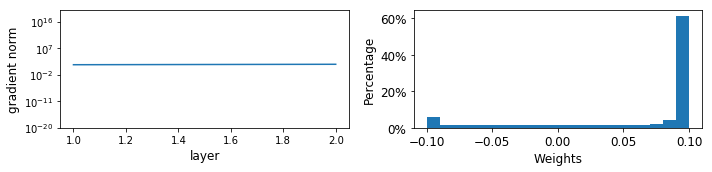

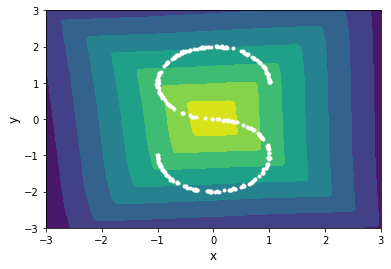

iter 899	disc cost	-1018.10876465


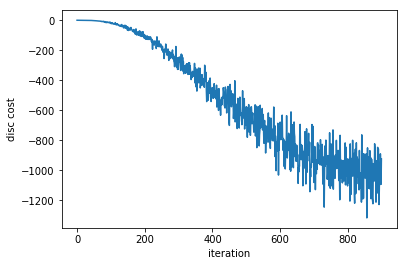

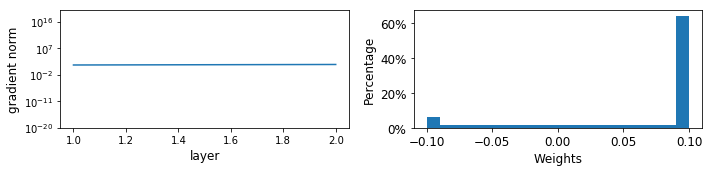

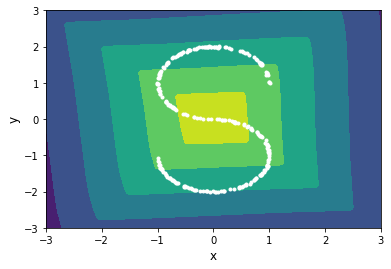

iter 999	disc cost	-1018.16986084


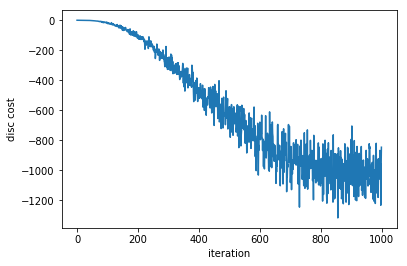

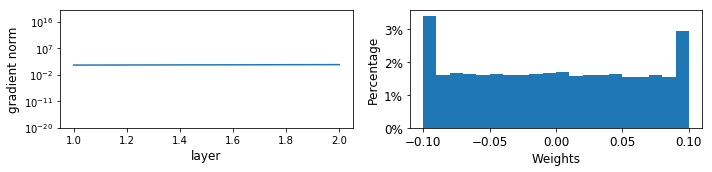

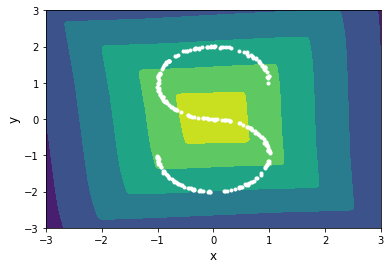

iter 1099	disc cost	-1019.96514893


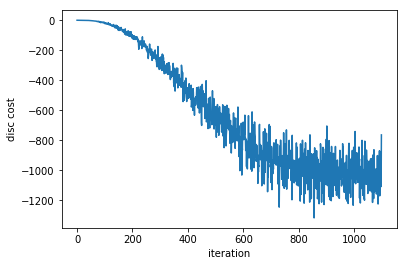

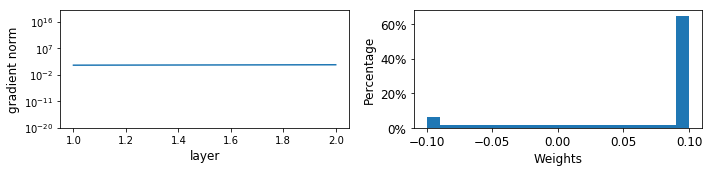

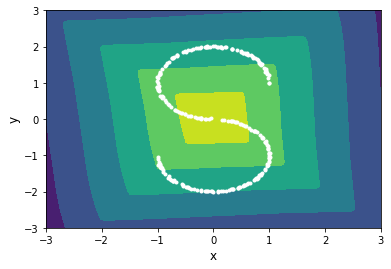

iter 1199	disc cost	-1013.27130127


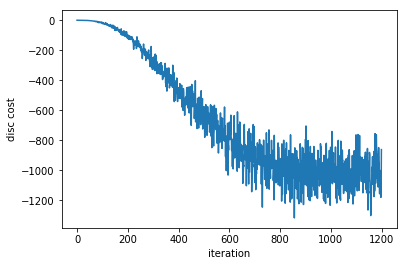

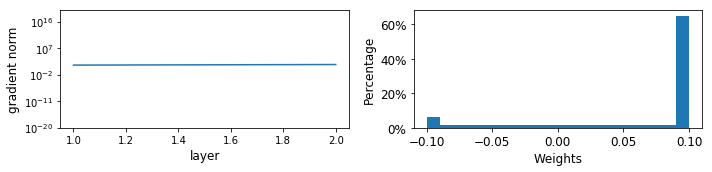

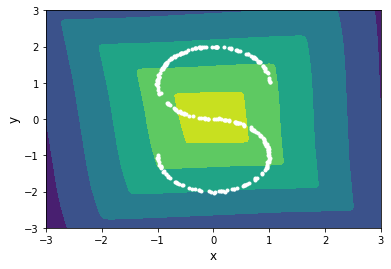

iter 1299	disc cost	-1003.40844727


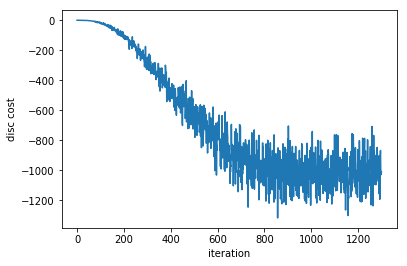

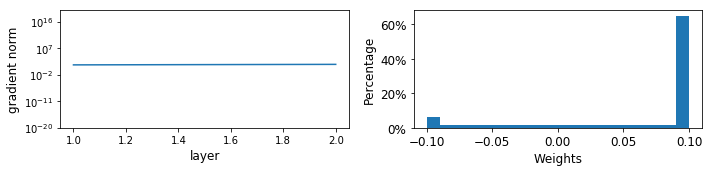

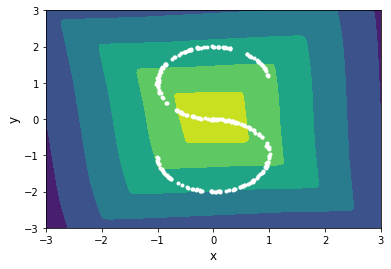

iter 1399	disc cost	-1000.37023926


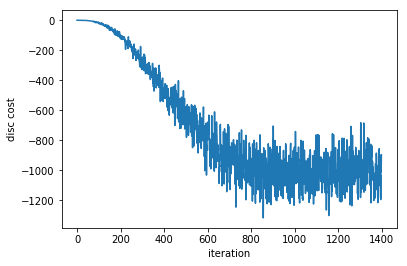

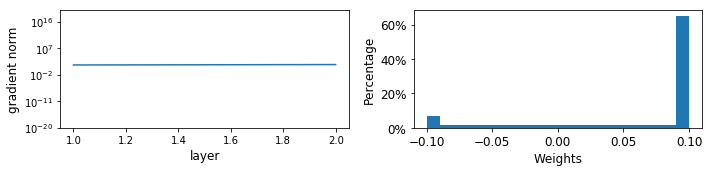

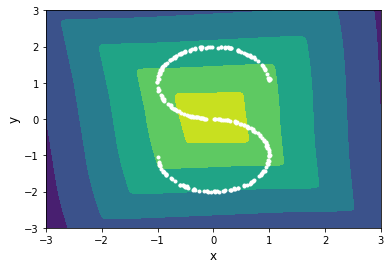

iter 1499	disc cost	-1050.54272461


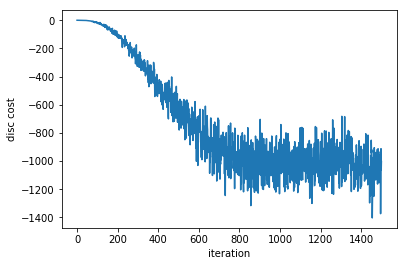

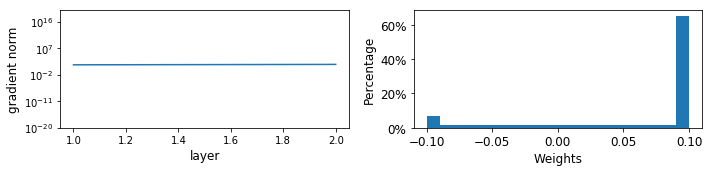

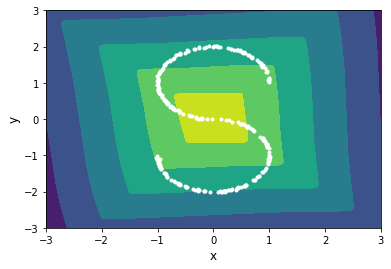

iter 1599	disc cost	-1022.52740479


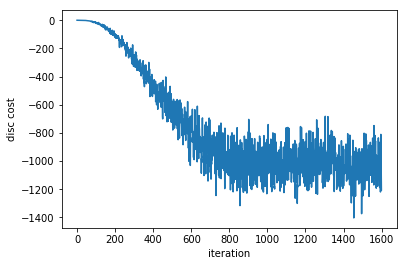

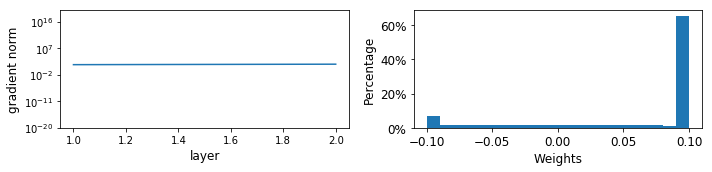

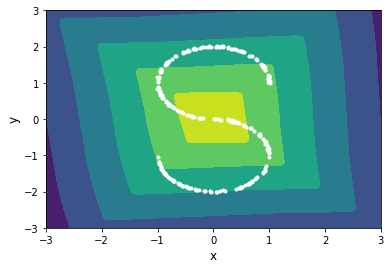

iter 1699	disc cost	-1014.67181396


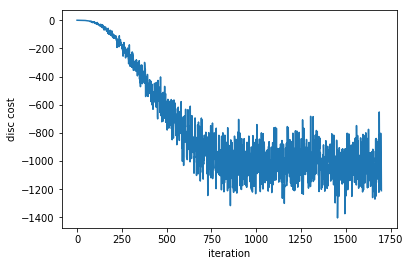

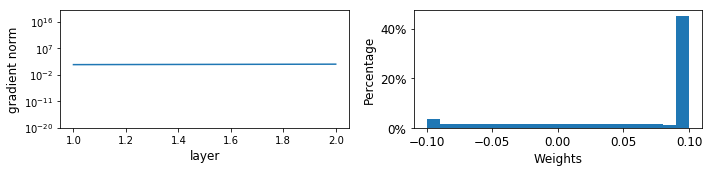

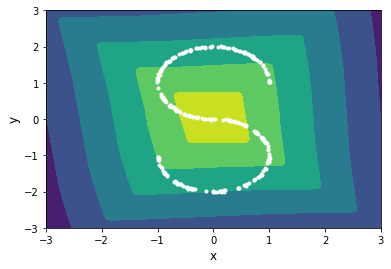

iter 1799	disc cost	-1041.4519043


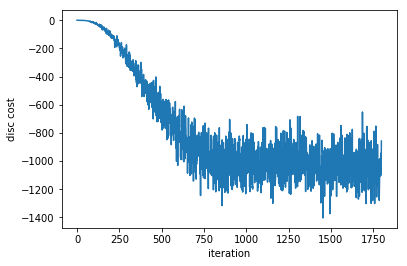

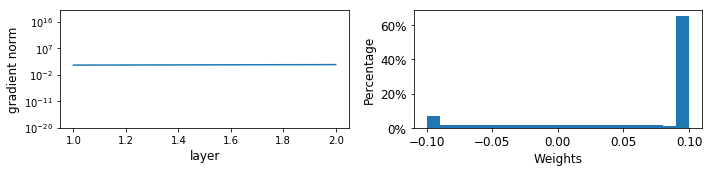

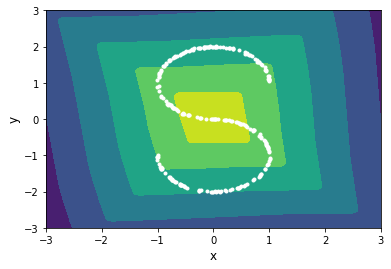

iter 1899	disc cost	-1028.89648438


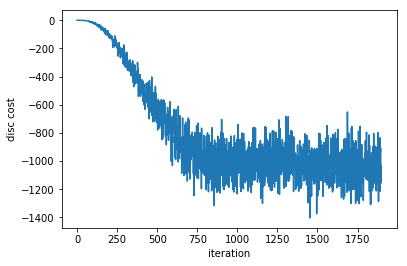

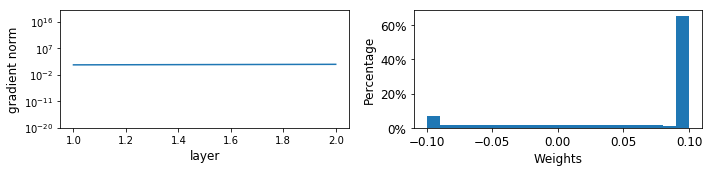

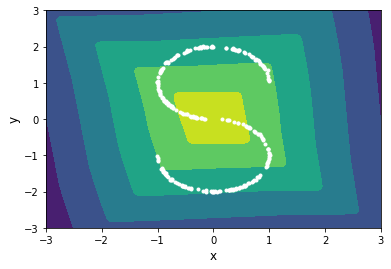

iter 1999	disc cost	-1012.80383301


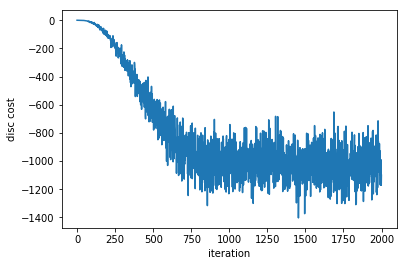

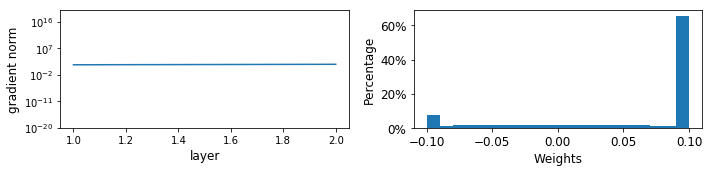

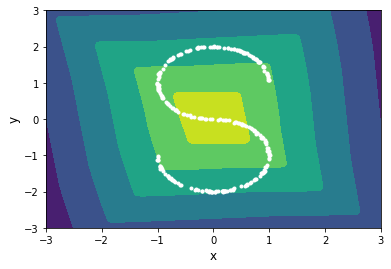

iter 2099	disc cost	-1022.31671143


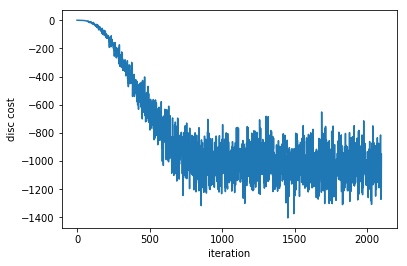

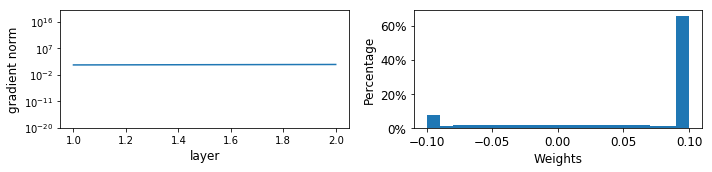

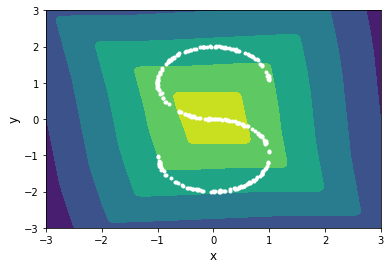

iter 2199	disc cost	-1012.78936768


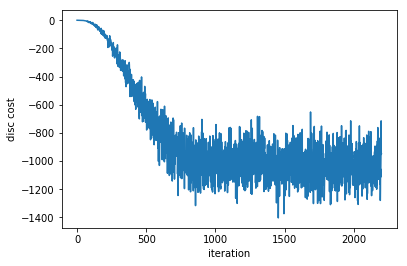

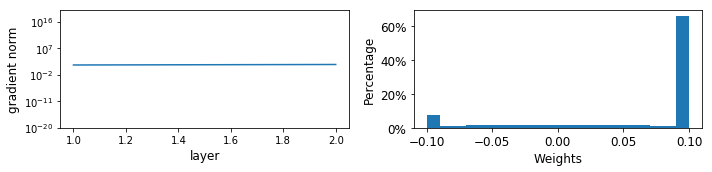

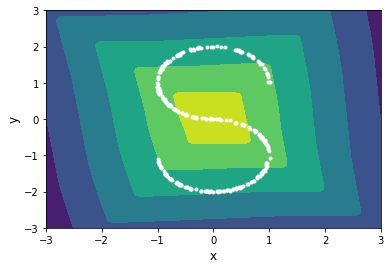

iter 2299	disc cost	-1018.36206055


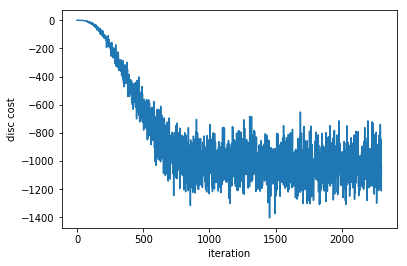

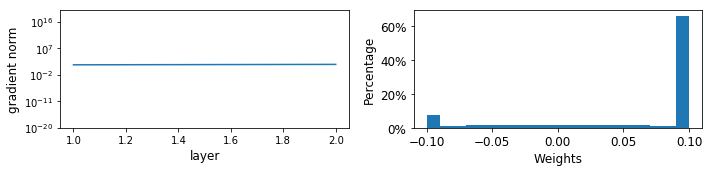

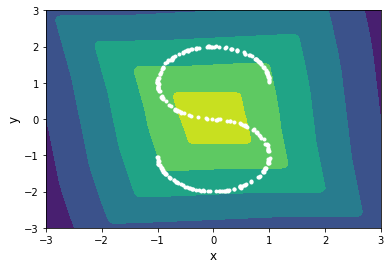

iter 2399	disc cost	-992.507751465


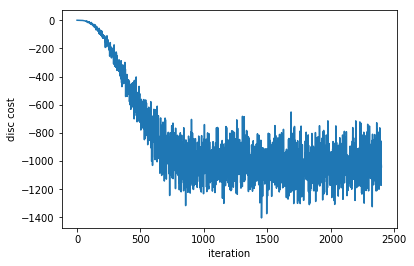

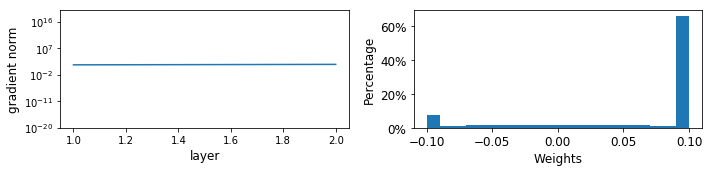

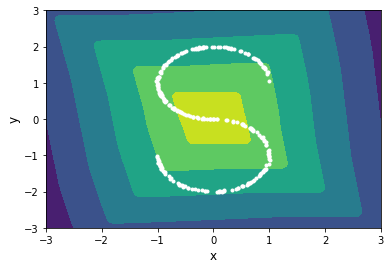

W1206 03:34:44.301011 140714493970304 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/tensorflow_estimator/python/estimator/api/_v1/estimator/__init__.py:12: The name tf.estimator.inputs is deprecated. Please use tf.compat.v1.estimator.inputs instead.



KeyboardInterrupt: ignored

In [2]:
import os, sys
sys.path.append('improved_wgan_training')
import random
import time

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sklearn.datasets

import tflib as lib
import tflib.ops.linear
import tflib.plot

MODE = 'wgan' # wgan or wgan-gp
DIM = 512 # number of units in fully connected layers
FIXED_GENERATOR = True # whether to hold the generator fixed at real data plus Gaussian noise
LAMBDA = .1 # gradient penalty coefficient
CRITIC_ITERS = 5 # number of critic iterations per generator iteration
BATCH_SIZE = 256 # Batch size
ITERS = 100000 # number of generator iterations to train for
N_LAYER = 4   # number of layers for the generator and critic

def ReLULayer(name, n_in, n_out, inputs):
    output = lib.ops.linear.Linear(
        name+'.Linear',
        n_in,
        n_out,
        inputs,
        initialization='he'
    )
    output = tf.nn.relu(output)
    return output

def Generator(n_samples, real_data):
    if FIXED_GENERATOR:
        return real_data + (1.*tf.random_normal(tf.shape(real_data)))
    else:
        noise = tf.random_normal([n_samples, 2])
        output = ReLULayer('Generator.1', 2, DIM, noise)
        for i in range(2, N_LAYER):
            output = ReLULayer('Generator.{}'.format(i), DIM, DIM, output)

        output = lib.ops.linear.Linear('Generator.{}'.format(N_LAYER), DIM, 2, output)
        return output

def Discriminator(inputs):
    output = ReLULayer('Discriminator.1', 2, DIM, inputs)
    for i in range(2, N_LAYER):
        output = ReLULayer('Discriminator.{}'.format(i), DIM, DIM, output)
    output = lib.ops.linear.Linear('Discriminator.{}'.format(N_LAYER), DIM, 1, output)
    return tf.reshape(output, [-1])

real_data = tf.placeholder(tf.float32, shape=[None, 2])
fake_data = Generator(BATCH_SIZE, real_data)

disc_real = Discriminator(real_data)
disc_fake = Discriminator(fake_data)

# WGAN loss
disc_cost = tf.reduce_mean(disc_fake) - tf.reduce_mean(disc_real)
gen_cost = -tf.reduce_mean(disc_fake)

# WGAN gradient penalty
if MODE == 'wgan-gp':
    alpha = tf.random_uniform(
        shape=[BATCH_SIZE,1], 
        minval=0.,
        maxval=1.
    )
    interpolates = alpha*real_data + ((1-alpha)*fake_data)
    disc_interpolates = Discriminator(interpolates)
    gradients = tf.gradients(disc_interpolates, [interpolates])[0]
    slopes = tf.sqrt(tf.reduce_sum(tf.square(gradients), reduction_indices=[1]))
    gradient_penalty = tf.reduce_mean((slopes-1)**2)
 
    disc_cost += LAMBDA*gradient_penalty

disc_params = lib.params_with_name('Discriminator')
gen_params = lib.params_with_name('Generator')

if MODE == 'wgan-gp':
    disc_train_op = tf.train.AdamOptimizer(
        learning_rate=1e-4, 
        beta1=0.5, 
        beta2=0.9
    ).minimize(
        disc_cost, 
        var_list=disc_params
    )


    if len(gen_params) > 0:
        gen_train_op = tf.train.AdamOptimizer(
            learning_rate=1e-4, 
            beta1=0.5, 
            beta2=0.9
        ).minimize(
            gen_cost, 
            var_list=gen_params
        )
    else:
        gen_train_op = tf.no_op()

else:
    disc_train_op = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(
        disc_cost, 
        var_list=disc_params
    )
    if len(gen_params) > 0:
        gen_train_op = tf.train.RMSPropOptimizer(learning_rate=5e-5).minimize(
            gen_cost, 
            var_list=gen_params
        )
    else:
        gen_train_op = tf.no_op()

    clip_ops = []
    for var in disc_params:
        clip_bounds = [-.1, .1]
        clip_ops.append(
            tf.assign(
                var, 
                tf.clip_by_value(var, clip_bounds[0], clip_bounds[1])
            )
        )
    clip_disc_weights = tf.group(*clip_ops)

frame_index = [0]
def generate_image(true_dist):
    """
    Generates a plot of the true distribution, and the critic.
    """
    N_POINTS = 128
    RANGE = 3

    points = np.zeros((N_POINTS, N_POINTS, 2), dtype='float32')
    points[:,:,0] = np.linspace(-RANGE, RANGE, N_POINTS)[:,None]
    points[:,:,1] = np.linspace(-RANGE, RANGE, N_POINTS)[None,:]
    points = points.reshape((-1,2))
    samples, disc_map = session.run(
        [fake_data, disc_real], 
        feed_dict={real_data:points}
    )
    disc_map = session.run(disc_real, feed_dict={real_data:points})

    plt.clf()

    x = y = np.linspace(-RANGE, RANGE, N_POINTS)
    plt.contourf(x,y,disc_map.reshape((len(x), len(y))).transpose())

    plt.xlabel('x', fontsize=12)
    plt.ylabel('y', fontsize=12)

    plt.scatter(true_dist[:, 0], true_dist[:, 1], c='white',  marker='.')

    frame_index[0] += 1
    plt.show()

def inf_train_gen():
      while True:
          data = sklearn.datasets.make_s_curve(n_samples=BATCH_SIZE, noise=0.01, random_state=None)[0]
          data = data.astype('float32')[:, [0, 2]]
          data /= 1 # stdev plus a little
          yield data

def generate_weight_image(grad):
    """
    Generates a plot of the gradient norm of each layer, and the weight distribution of the critic.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2.5))

    ax = axes.ravel()
    list_weight_norm = []
    for i in range(2, N_LAYER * 2):
        for j in range(len(disc_params)):
          if '{}.Linear.W'.format(i) in disc_params[j].name:
              list_weight_norm.append(np.linalg.norm(gradval[j]))
    ax[0].plot([1, 2], list_weight_norm)
    ax[0].set_xlabel('layer', fontsize=12)
    ax[0].set_ylabel('gradient norm', fontsize=12)

    ax[0].set_yscale('log')
    if MODE == 'wgan':
        ax[0].set_ylim(1e-20, 1e20)
    else:
        ax[0].set_ylim(1e-20, 1e20)

    network_weights = np.vstack([np.expand_dims(weights[i].flatten(), axis = 1) for i in range(len(weights))])
    hist_weights = np.ones(len(network_weights))/len(network_weights)
    if MODE == 'wgan':
        ax[1].hist(network_weights, weights = hist_weights, bins = 20, range = clip_bounds)
    else:
        ax[1].hist(network_weights, weights = hist_weights, bins = 50, range = (-0.5, 0.5))
    if MODE == 'wgan':
        ax[1].set_xticks(np.linspace(clip_bounds[0], clip_bounds[1], 5))
    else:
        ax[1].set_xticks(np.arange(-0.5, 0.75, 0.25))

    ax[1].set_xlabel('Weights', fontsize=12)
    ax[1].set_ylabel('Percentage', fontsize=12)
    ax[1].tick_params(axis="x", labelsize=12)
    ax[1].tick_params(axis="y", labelsize=12)
    ax[1].yaxis.set_major_formatter(matplotlib.ticker.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

    plt.tight_layout()
    plt.show()

grad = tf.gradients(disc_cost, disc_params)

# Train GAN networks
with tf.Session() as session:
    session.run(tf.initialize_all_variables())
    gen = inf_train_gen()
    for iteration in xrange(ITERS):
        # Train generator
        if iteration > 0:
            _ = session.run(gen_train_op)
        # Train critic
        for i in xrange(CRITIC_ITERS):
            _data = gen.next()
            _disc_cost, _, gradval, weights = session.run(
                [disc_cost, disc_train_op, grad, disc_params],
                feed_dict={real_data: _data}
            )
            if MODE == 'wgan':
                _ = session.run([clip_disc_weights])

        lib.plot.plot('disc cost', _disc_cost)
        if iteration % 100 == 99:
            lib.plot.flush()
            generate_weight_image(gradval)
            generate_image(_data)

        lib.plot.tick()